In [1]:
import sys
sys.path.append('../..')
sys.path.append('../../APDFT')
sys.path.append('../../helper_code')
sys.path.append('../data')

import pickle
from pyscf import gto, scf, dft, cc
from ase import Atoms
from ase.io import write
from ase.visualize import view
import numpy as np
import pandas as pd
import pyscf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import basis_set_exchange as bse
from APDFT.FcMole import *
import os
import ast
from copy import deepcopy
from IPython.display import display
from helper_code.data_processing import *
from helper_code.util import charge_arr_to_str

%load_ext autoreload
%autoreload 2
from APDFT.AP_class import APDFT_perturbator as AP

## Load Dataset ##

In [3]:
coronene_energy_raw_data = np.load("../data/coronene_raw_data/coronene_mutants_pbe_pcx2_corrected3.npz", allow_pickle=True)
charges, total_energy, electronic_energy = coronene_energy_raw_data['charges'], coronene_energy_raw_data['energies'], coronene_energy_raw_data['electronic']
print(list(coronene_energy_raw_data.keys()))
print(charges.shape)
print(total_energy.shape)

['charges', 'names', 'energies', 'electronic']
(2043, 36)
(2043,)


In [19]:
atomic_e_tot = {}

carbon_mol = gto.M(atom="C 0 0 0", basis=bse.get_basis('pcX-2',fmt="nwchem",elements=[5, 6, 7]), unit='Angstrom', spin=2)
carbon_DFT = scf.RKS(carbon_mol) # .newton()
carbon_DFT.xc = "PBE" # specify the exchange-correlation functional used for DFT
carbon_DFT.kernel()
atomic_e_tot['C'] = carbon_DFT.energy_tot() # -37.4675874241476

converged SCF energy = -37.7954921437559


In [21]:
boron_mol = gto.M(atom="B 0 0 0", basis=bse.get_basis('pcX-2',fmt="nwchem",elements=[5, 6, 7]), unit='Angstrom', spin=1)
boron_DFT = scf.ROKS(boron_mol)
boron_DFT.xc = "PBE" # specify the exchange-correlation functional used for DFT
boron_DFT.kernel()
atomic_e_tot['B'] = boron_DFT.energy_tot() # -37.7954921438287

converged SCF energy = -24.6096690439285


In [22]:
nitrogen_mol = gto.M(atom="N 0 0 0", basis=bse.get_basis('pcX-2',fmt="nwchem",elements=[5, 6, 7]), unit='Angstrom', spin=3)
nitrogen_DFT = scf.ROKS(nitrogen_mol)
nitrogen_DFT.xc = "PBE" # specify the exchange-correlation functional used for DFT
nitrogen_DFT.kernel()
atomic_e_tot['N'] = nitrogen_DFT.energy_tot() # -37.7954921438287

converged SCF energy = -54.532201627682


In [3]:
columns = ['charges', 'total energy']
coronene_energy_data = pd.DataFrame(columns=columns)
coronene_energy_data['charges'] = charges.tolist()
coronene_energy_data['total energy'] = total_energy.tolist()

CORONENE_REF_ENERGY = -921.076917318163
coronene_energy_data['delta total energy'] = coronene_energy_data['total energy'].apply(lambda x: CORONENE_REF_ENERGY-x)

hessian_data = np.load("coronene_pbe_pcX2_hessian.npz", allow_pickle=True)
g, H = hessian_data['g'], hessian_data['H']
ANM_eigval, Q = np.linalg.eig(H)
Q_inv = np.linalg.inv(Q)

coronene_energy_data['dx'] = None
coronene_energy_data['APDFT2'] = None
coronene_energy_data['DD e_tot'] = None

for index, row in coronene_energy_data.iterrows():
    ref_charge = np.full(24, 6)
    dx = np.array(row['charges'][:24]) - ref_charge
    apdft2 = CORONENE_REF_ENERGY + dx.dot(g) + 0.5*np.einsum('i,ij,j', dx, H ,dx)
    target_energy = coronene_energy_data.at[index, 'total energy']
    coronene_energy_data.at[index, 'dx'] = dx
    coronene_energy_data.at[index, 'APDFT2'] = apdft2
    coronene_energy_data.at[index, 'DD e_tot'] = apdft2 - target_energy

print(f"num row: {coronene_energy_data.shape[0]}")
display(coronene_energy_data.head(3))

num row: 2043


,charges,total energy,delta total energy,dx,APDFT2,DD e_tot
0,"[7, 6, 5, 6, 7, 7, 6, 7, 7, 5, 6, 7, 6, 6, 6, ...",-940.815104,19.738187,"[1, 0, -1, 0, 1, 1, 0, 1, 1, -1, 0, 1, 0, 0, 0...",-940.516158,0.298946
1,"[5, 5, 7, 5, 5, 7, 5, 5, 7, 7, 7, 7, 5, 7, 5, ...",-961.301972,40.225055,"[-1, -1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1,...",-960.852398,0.449574
2,"[5, 6, 6, 7, 7, 6, 7, 6, 5, 6, 5, 5, 7, 7, 5, ...",-951.218399,30.141481,"[-1, 0, 0, 1, 1, 0, 1, 0, -1, 0, -1, -1, 1, 1,...",-951.049917,0.168482


In [4]:
print(ANM_eigval)

[ 0.02381251 -3.04617621 -3.04616976 -3.23669103 -3.21956263 -3.2195548
 -3.26798949 -3.47956221 -3.30142548 -3.30407914 -3.30407732 -3.33002348
 -3.33003006 -3.45453494 -3.45453387 -3.41299841 -3.4269054  -3.42788605
 -3.4278868  -3.38343689 -3.38343401 -3.39746241 -3.39967488 -3.39967583]


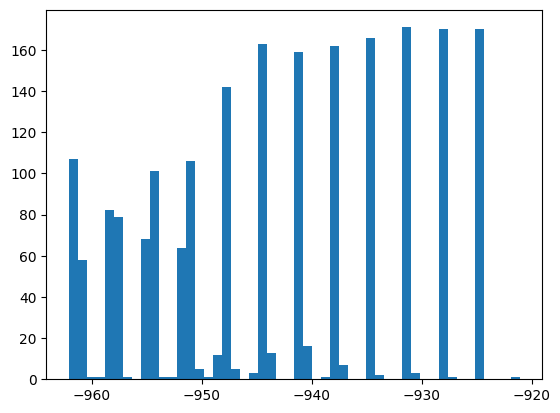

In [4]:
plt.hist(coronene_energy_data['total energy'].tolist(), bins=50)
plt.show()

21.65609921872822
11.542046585493337


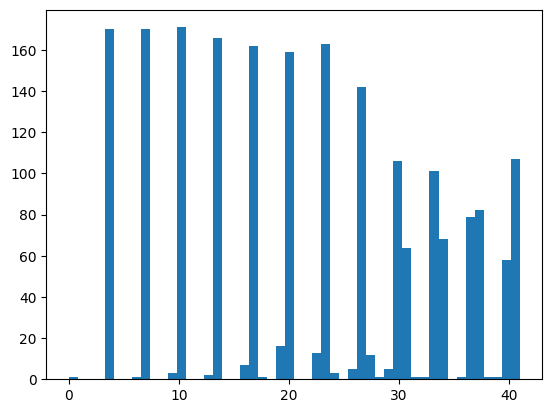

In [5]:
print(np.array(coronene_energy_data['delta total energy'].mean()))
print(np.array(coronene_energy_data['delta total energy'].std()))
plt.hist(coronene_energy_data['delta total energy'].tolist(), bins=50)
plt.show()

0.14562546462994108
0.3846827129334702


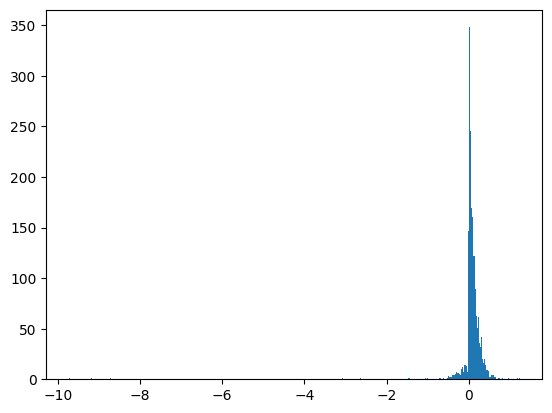

In [6]:
print(np.abs(np.array(coronene_energy_data['DD e_tot'])).mean())
print(np.abs(np.array(coronene_energy_data['DD e_tot'])).std())
plt.hist(coronene_energy_data['DD e_tot'].tolist(), bins='auto')
plt.show()

## Distribution Analysis ##

In [7]:
max = np.max(coronene_energy_data['DD e_tot'])
q1 = np.percentile(coronene_energy_data['DD e_tot'], 25)
median = np.percentile(coronene_energy_data['DD e_tot'], 50)
q3 = np.percentile(coronene_energy_data['DD e_tot'], 75)
min = np.min(coronene_energy_data['DD e_tot'])

print("Minimum value:", min)
print("25th percentile (Q1):", q1)
print("Median (Q2):", median)
print("75th percentile (Q3):", q3)
print("Maximum value:", max)

Minimum value: -9.739871968714965
25th percentile (Q1): 0.02141949518011188
Median (Q2): 0.07089399379208317
75th percentile (Q3): 0.16351790783880915
Maximum value: 1.2392988222109125


In [13]:

outliers = coronene_energy_data[(coronene_energy_data['DD e_tot'] < -2)]
print(outliers.shape)

display(outliers)
outlier_charges = []
outlier_energies = []
outlier_errors = []
for index, rows in outliers.iterrows():
    print(f"{rows['charges']}, Error: {rows['DD e_tot']:.4f}, Number of doping: {np.count_nonzero(rows['dx'])}")
    outlier_charges.append(rows['charges'])
    outlier_energies.append(rows['total energy'])
    outlier_errors.append(rows['DD e_tot'])

(5, 7)


,charges,total energy,delta total energy,dx,APDFT2,DD e_tot,num dope
259,"[5, 6, 5, 5, 6, 7, 7, 6, 7, 5, 7, 7, 5, 5, 6, ...",-938.387373,17.310456,"[-1, 0, -1, -1, 0, 1, 1, 0, 1, -1, 1, 1, -1, -...",-947.585664,-9.198291,16
977,"[7, 7, 5, 5, 6, 7, 5, 6, 7, 6, 7, 7, 5, 7, 5, ...",-945.544171,24.467254,"[1, 1, -1, -1, 0, 1, -1, 0, 1, 0, 1, 1, -1, 1,...",-954.272139,-8.727968,20
1396,"[7, 5, 5, 7, 5, 5, 6, 7, 7, 5, 7, 5, 7, 7, 6, ...",-955.161267,34.084349,"[1, -1, -1, 1, -1, -1, 0, 1, 1, -1, 1, -1, 1, ...",-957.795444,-2.634177,22
1853,"[7, 5, 5, 5, 5, 7, 5, 7, 5, 5, 7, 7, 5, 7, 6, ...",-948.363808,27.286891,"[1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1...",-958.10368,-9.739872,22
2022,"[6, 5, 6, 5, 7, 6, 6, 7, 7, 5, 6, 7, 7, 7, 6, ...",-941.054095,19.977177,"[0, -1, 0, -1, 1, 0, 0, 1, 1, -1, 0, 1, 1, 1, ...",-944.125087,-3.070993,14


[5, 6, 5, 5, 6, 7, 7, 6, 7, 5, 7, 7, 5, 5, 6, 6, 7, 6, 7, 7, 5, 5, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], Error: -9.1983, Number of doping: 16
[7, 7, 5, 5, 6, 7, 5, 6, 7, 6, 7, 7, 5, 7, 5, 7, 5, 7, 6, 5, 5, 5, 5, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], Error: -8.7280, Number of doping: 20
[7, 5, 5, 7, 5, 5, 6, 7, 7, 5, 7, 5, 7, 7, 6, 5, 7, 7, 7, 5, 5, 7, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], Error: -2.6342, Number of doping: 22
[7, 5, 5, 5, 5, 7, 5, 7, 5, 5, 7, 7, 5, 7, 6, 7, 5, 7, 5, 7, 6, 7, 7, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], Error: -9.7399, Number of doping: 22
[6, 5, 6, 5, 7, 6, 6, 7, 7, 5, 6, 7, 7, 7, 6, 5, 6, 5, 6, 5, 6, 5, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], Error: -3.0710, Number of doping: 14


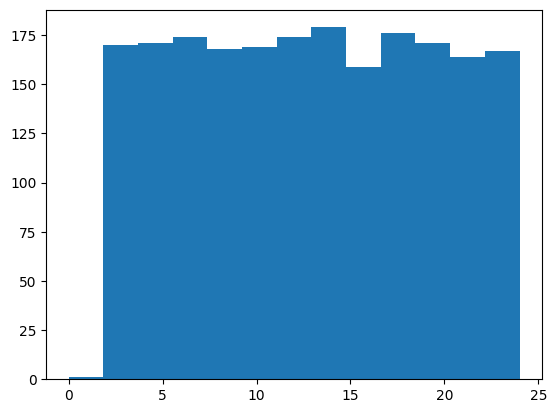

0 doping count: 1. E Mean: -921.0769. E Std: nan. Delta Mean: 0.0000. Delta Std: nan
2 doping count: 170. E Mean: -924.4205. E Std: 0.0240. Delta Mean: 0.0089. Delta Std: 0.0017
4 doping count: 171. E Mean: -927.7682. E Std: 0.0503. Delta Mean: 0.0213. Delta Std: 0.0128
6 doping count: 174. E Mean: -931.1103. E Std: 0.1001. Delta Mean: 0.0340. Delta Std: 0.0533
8 doping count: 168. E Mean: -934.4687. E Std: 0.1192. Delta Mean: 0.0490. Delta Std: 0.0595
10 doping count: 169. E Mean: -937.8105. E Std: 0.1729. Delta Mean: 0.0592. Delta Std: 0.0977
12 doping count: 174. E Mean: -941.1422. E Std: 0.2294. Delta Mean: 0.0622. Delta Std: 0.1297
14 doping count: 179. E Mean: -944.4907. E Std: 0.3573. Delta Mean: 0.0740. Delta Std: 0.2794
16 doping count: 159. E Mean: -947.7549. E Std: 0.7906. Delta Mean: 0.0604. Delta Std: 0.7555
18 doping count: 176. E Mean: -951.2524. E Std: 0.3074. Delta Mean: 0.1314. Delta Std: 0.1925
20 doping count: 171. E Mean: -954.5041. E Std: 0.7687. Delta Mean: 0.086

In [10]:
coronene_energy_data['num dope'] = coronene_energy_data['dx'].apply(lambda arr: np.count_nonzero(arr))
plt.hist(coronene_energy_data['num dope'].tolist(), bins=13)
plt.show()
num_doped = {}
for i in range(0, 25, 2):
    num_doped[i] = coronene_energy_data[coronene_energy_data['num dope'] == i].shape[0]
    E_mean = coronene_energy_data[coronene_energy_data['num dope'] == i]['total energy'].mean()
    E_std = coronene_energy_data[coronene_energy_data['num dope'] == i]['total energy'].std()
    D_mean = coronene_energy_data[coronene_energy_data['num dope'] == i]['DD e_tot'].mean()
    D_std = coronene_energy_data[coronene_energy_data['num dope'] == i]['DD e_tot'].std()
    print(f"{i} doping count: {num_doped[i]}. E Mean: {E_mean:.4f}. E Std: {E_std:.4f}. Delta Mean: {D_mean:.4f}. Delta Std: {D_std:.4f}")

## Outliers ##

In [12]:
xyz_file = '../data/coronene_raw_data/coronene_opt_pbe0_pcX2.xyz'
with open(xyz_file, 'r') as f:
    lines = f.readlines()[2:]  # Skip the first two lines (atom count and comment)
    atoms = [line.split() for line in lines]
num_mol = charges.shape[0]

# Extract atomic symbols and coordinates
symbols = [atom[0] for atom in atoms]
all_atoms_coord = [[float(atom[1]), float(atom[2]), float(atom[3])] for atom in atoms]
coordinates = np.tile(np.array(all_atoms_coord), (num_mol, 1, 1))

In [31]:
i = 0
print("Charge:", outlier_charges[i])
print("Total energy:", outlier_energies[i])
print("2nd order alchemy prediction error:", outlier_errors[i])
outlier0 = Atoms(symbols=charge_arr_to_str(outlier_charges[i]), positions=coordinates[i])
view(outlier0, viewer='x3d')

Charge: [5, 6, 5, 5, 6, 7, 7, 6, 7, 5, 7, 7, 5, 5, 6, 6, 7, 6, 7, 7, 5, 5, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Total energy: -938.3873732115155
2nd order alchemy prediction error: -9.198290540712264


In [24]:
i = 1
print("Charge:", outlier_charges[i])
print("Total energy:", outlier_energies[i])
print("2nd order alchemy prediction error:", outlier_errors[i])
outlier0 = Atoms(symbols=charge_arr_to_str(outlier_charges[i]), positions=coordinates[i])
view(outlier0, viewer='x3d')

Charge: [7, 7, 5, 5, 6, 7, 5, 6, 7, 6, 7, 7, 5, 7, 5, 7, 5, 7, 6, 5, 5, 5, 5, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Total energy: -945.5441708497613
2nd order alchemy prediction error: -8.72796824582474


In [25]:
i = 2
print("Charge:", outlier_charges[i])
print("Total energy:", outlier_energies[i])
print("2nd order alchemy prediction error:", outlier_errors[i])
outlier0 = Atoms(symbols=charge_arr_to_str(outlier_charges[i]), positions=coordinates[i])
view(outlier0, viewer='x3d')

Charge: [7, 5, 5, 7, 5, 5, 6, 7, 7, 5, 7, 5, 7, 7, 6, 5, 7, 7, 7, 5, 5, 7, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Total energy: -955.1612666370843
2nd order alchemy prediction error: -2.6341772092663405


In [26]:
i = 3
print("Charge:", outlier_charges[i])
print("Total energy:", outlier_energies[i])
print("2nd order alchemy prediction error:", outlier_errors[i])
outlier0 = Atoms(symbols=charge_arr_to_str(outlier_charges[i]), positions=coordinates[i])
view(outlier0, viewer='x3d')

Charge: [7, 5, 5, 5, 5, 7, 5, 7, 5, 5, 7, 7, 5, 7, 6, 7, 5, 7, 5, 7, 6, 7, 7, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Total energy: -948.3638082864436
2nd order alchemy prediction error: -9.739871968714965


In [27]:
i = 4
print("Charge:", outlier_charges[i])
print("Total energy:", outlier_energies[i])
print("2nd order alchemy prediction error:", outlier_errors[i])
outlier0 = Atoms(symbols=charge_arr_to_str(outlier_charges[i]), positions=coordinates[i])
view(outlier0, viewer='x3d')

Charge: [6, 5, 6, 5, 7, 6, 6, 7, 7, 5, 6, 7, 7, 7, 6, 5, 6, 5, 6, 5, 6, 5, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Total energy: -941.054094537591
2nd order alchemy prediction error: -3.070992790206219


In [30]:
i = 4
print("Charge:", outlier_charges[i])
print("Total energy:", outlier_energies[i])
print("2nd order alchemy prediction error:", outlier_errors[i])
outlier0 = Atoms(symbols=charge_arr_to_str(outlier_charges[i]), positions=coordinates[i])
view(outlier0, viewer='x3d')

Charge: [6, 5, 6, 5, 7, 6, 6, 7, 7, 5, 6, 7, 7, 7, 6, 5, 6, 5, 6, 5, 6, 5, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Total energy: -941.054094537591
2nd order alchemy prediction error: -3.070992790206219


## Data Processing ##

In [8]:
rotation_mapping = {0:21, 21:22, 22:15, 15:12, 12:7, 7:0, 
                    1:20, 20:23, 23:14, 14:13, 13:6, 6:1,
                    2:19, 19:16, 16:11, 11:8, 8:5, 5:2,
                    3:18, 18:17, 17:10, 10:9, 9:4, 4:3}

reflection_mapping1 = {0:6, 6:0, 7:1, 1:7, 5:5, 
                       8:2, 2:8, 4:4, 13:21, 21:13,
                       9:3, 3:9, 12:20, 20:12, 10:18, 18:10,
                       11:19, 19:11, 17:17, 14:22, 22:14, 16:16,
                       15:23, 23:15}

reflection_mapping2 = {0:1, 1:0, 6:21, 21:6, 5:2, 2:5,
                       7:20, 20:7, 4:3, 3:4, 8:19, 19:8,
                       9:18, 18:9, 13:22, 22:13, 10:17, 17:10,
                       12:23, 23:12, 11:16, 16:11, 14:15, 15:14}

In [9]:
coronene_energy_data['dx_lexi'] = coronene_energy_data['dx'].apply(
    lambda arr: coronene_lexi(arr.tolist(), rotation_mapping, reflection_mapping1, reflection_mapping2))

coronene_energy_data['c'] = coronene_energy_data['dx'].apply(
    lambda arr: (arr.reshape(1, 24)@Q).reshape(24,).tolist()) # column vector view: c = Q_inv @ dx

coronene_energy_data['c_lexi'] = coronene_energy_data['dx_lexi'].apply(
    lambda arr: (arr.reshape(1, 24)@Q).reshape(24,).tolist())

coronene_energy_data['CE'] = coronene_energy_data['c'].apply(
    lambda arr: compute_lambda_c(arr, ANM_eigval))

coronene_energy_data['CE_lexi'] = coronene_energy_data['c_lexi'].apply(
    lambda arr: compute_lambda_c(arr, ANM_eigval))

coronene_energy_data['CSE'] = coronene_energy_data['c'].apply(
    lambda arr: compute_lambda_c_square(arr, ANM_eigval))

coronene_energy_data['CSE_lexi'] = coronene_energy_data['c_lexi'].apply(
    lambda arr: compute_lambda_c_square(arr, ANM_eigval))

## Export Data ##

In [10]:
datasets = ['c', 'c_lexi', 'CE', 'CE_lexi', 'CSE', 'CSE_lexi']
columns = [f"coord{i}" for i in range(24)]

dataset_dict = {}
for data in datasets:
    dataset_dict[data] = pd.DataFrame(columns=columns)
    for i in range(24):
        dataset_dict[data][f"coord{i}"] = coronene_energy_data[data].apply(lambda arr: arr[i])

# display(dataset_dict['CSE_lexi'])

In [11]:
for key, dataframe in dataset_dict.items():
    dataframe.to_csv(f'../data/coronene_training_data/{key}.csv', index=False)

In [12]:
coronene_energy_data['delta total energy'].to_csv('../data/coronene_training_data/delta_total_energy.csv', index=False)
coronene_energy_data['DD e_tot'].to_csv('../data/coronene_training_data/DD_e_tot.csv', index=False)

## dx Uniqueness ##

In [13]:
from scipy.spatial.distance import cdist

dx_matrix = np.vstack(coronene_energy_data['dx'].tolist())
dx_lexi_matrix = np.vstack(coronene_energy_data['dx_lexi'].tolist())

# Calculate pairwise Euclidean distances between rows
dist_matrix = cdist(dx_lexi_matrix, dx_lexi_matrix, metric='euclidean')
np.fill_diagonal(dist_matrix, None)

zero_count = 0
for i in range(dist_matrix.shape[0]):
    for j in range(dist_matrix.shape[1]):
        if dist_matrix[i][j] == 0:
            zero_count += 1
            print("Identity:")
            print("dx 1: ", dx_matrix[i])
            print("dx 2: ", dx_matrix[j])
            print("resulting lexi mapping 1: ", dx_lexi_matrix[i])
            print("resulting lexi mapping 2: ", dx_lexi_matrix[j])
            print("energy of dx 1:", coronene_energy_data['delta total energy'][i])
            print("energy of dx 2:", coronene_energy_data['delta total energy'][j])
            print("delta delta energy of dx1:", coronene_energy_data['DD e_tot'][i])
            print("delta delta energy of dx2:", coronene_energy_data['DD e_tot'][j])
            print()
print("zero count:", zero_count)

Identity:
dx 1:  [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
dx 2:  [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
resulting lexi mapping 1:  [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
resulting lexi mapping 2:  [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
energy of dx 1: 3.3159814640620198
energy of dx 2: 3.315980060111201
delta delta energy of dx1: 0.009031734576524286
delta delta energy of dx2: 0.009014693319727485

Identity:
dx 1:  [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
dx 2:  [ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
resulting lexi mapping 1:  [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
resulting lexi mapping 2:  [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
energy of dx 1: 3.3159814640620198
energy of dx 2: 3.3159825021781444
delta delta ener

In [14]:
target_array = [0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0]

mask = coronene_energy_data['dx_lexi'].apply(lambda arr: arr.tolist() == target_array)
# display(mask)
coronene_energy_data.loc[mask, ['dx', 'dx_lexi', 'total energy']]

,dx,dx_lexi,total energy
500,"[0, 0, 0, 0, 0, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",-924.438154
910,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0,...","[0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",-924.438160
1691,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0,...","[0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",-924.438160


## Feature Distribution ##

[ 2.20000000e+00 -1.16415601e-03 -1.03283839e+00 ... -1.96144872e-01
  3.16074214e-01  8.27182623e-01]


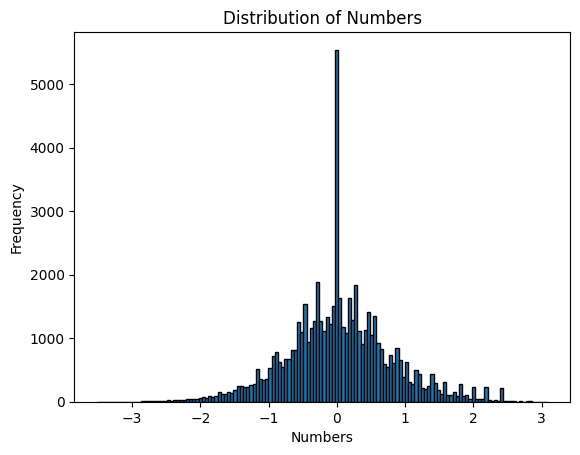

In [15]:
C = np.vstack(coronene_energy_data['c_lexi_nd'].tolist()).flatten()
print(C)
# Plot the histogram
plt.hist(C, bins='auto', edgecolor='black')
plt.xlabel('Numbers')
plt.ylabel('Frequency')
plt.title('Distribution of Numbers')

plt.show()

[ 2.20000000e+00 -3.67728801e-06  8.86895734e-01 ...  5.84328154e-02
  1.46301129e-01  1.00201119e+00]


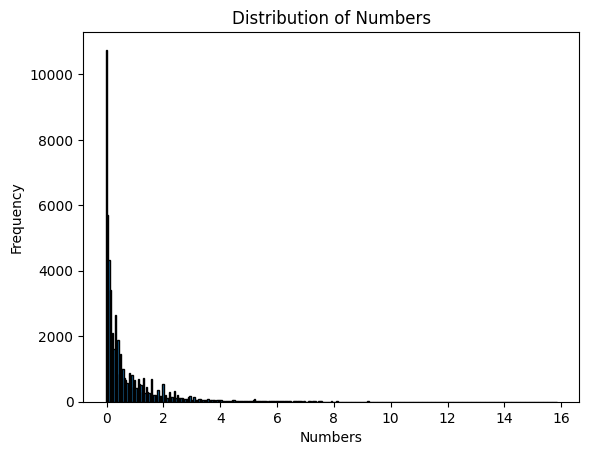

In [13]:
CSE = np.vstack(coronene_energy_data['CSE_lexi_nd'].tolist()).flatten()
print(CSE)
# Plot the histogram
plt.hist(CSE, bins='auto', edgecolor='black')
plt.xlabel('Numbers')
plt.ylabel('Frequency')
plt.title('Distribution of Numbers')

plt.show()

[ 2.2         0.00315876 -0.85869749 ... -0.29790641  0.46286955
  1.21135426]


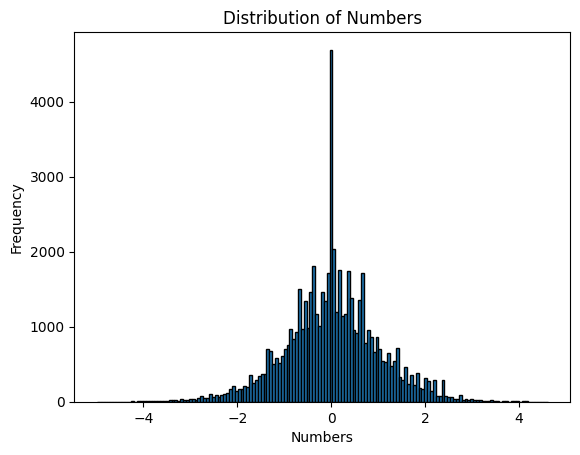

In [14]:
CE = np.vstack(coronene_energy_data['CE_lexi_nd'].tolist()).flatten()
print(CE)
# Plot the histogram
plt.hist(CE, bins='auto', edgecolor='black')
plt.xlabel('Numbers')
plt.ylabel('Frequency')
plt.title('Distribution of Numbers')

plt.show()